In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import os
import torch.nn.functional as F

In [ ]:
!pip install logomaker
import logomaker as lm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! wget https://github.com/adriadar/cw/raw/main/data/neg_class.csv
! wget https://github.com/adriadar/cw/raw/main/data/pos_class.csv

--2022-06-05 14:34:49--  https://github.com/adriadar/cw/raw/main/data/neg_class.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-06-05 14:34:50 ERROR 404: Not Found.

--2022-06-05 14:34:50--  https://github.com/adriadar/cw/raw/main/data/pos_class.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-06-05 14:34:50 ERROR 404: Not Found.



In [2]:
pos = pd.read_csv('pos_class.csv', header=None, names=['seq'])
neg = pd.read_csv('neg_class.csv', header=None, names=['seq'])

In [3]:
neg = list(neg.seq)
pos = list(pos.seq)

In [4]:
import random
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [5]:
set_random_seed(42)

In [ ]:
def convertLines(lines):
    newLines = np.zeros((len(lines), 4, len(lines[0])), dtype=int)
    for i, line in enumerate(lines):
        for j, c in enumerate(line.strip()):
            if c == 'A' or c == 'a':
                v = [1,0,0,0]
            elif c == 'C' or c == 'c':
                v = [0,1,0,0]
            elif c == 'G' or c == 'g':
                v = [0,0,1,0]
            elif c == 'T' or c == 't':
                v = [0,0,0,1]
            else:
                raise ValueError()
            newLines[i, :, j] = np.array(v)
    return newLines


In [ ]:
X = convertLines(pos + neg)
y = np.array([1] * len(pos) + [0] * len(neg))

In [ ]:
X.shape

(684, 4, 800)

In [ ]:
X = X.reshape((X.shape[0], 1, 3200))
X.shape

(684, 1, 3200)

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, shuffle=True, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, shuffle=True, test_size=0.5)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((478, 1, 3200), (478,), (103, 1, 3200), (103,), (103, 1, 3200), (103,))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
lr = LogisticRegression(random_state=0).fit(X_train.reshape(478, 3200), y_train)
lr.score(X_val.reshape(103, 3200), y_val)

0.9223300970873787

In [ ]:
y_pred = lr.predict(X_val.reshape(103, 3200))
f1_score(y_val, y_pred)

0.7999999999999999

In [ ]:
gb = GradientBoostingClassifier(random_state=0).fit(X_train.reshape(478, 3200), y_train)
gb.score(X_val.reshape(103, 3200), y_val)

0.7864077669902912

In [ ]:
y_pred = gb.predict(X_val.reshape(103, 3200))
f1_score(y_val, y_pred)

0.08333333333333333

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def preprocess(self, x):
        return torch.from_numpy(x).float()

    def __getitem__(self, idx):
        return self.preprocess(self.x[idx]), self.y[idx]

    def __len__(self,):
        return len(self.x)

In [ ]:
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)


train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                    batch_size=32, shuffle=True,
                                    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                    batch_size=64, shuffle=False,
                                    num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                    batch_size=64, shuffle=False,
                                    num_workers=2)

In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    for (seq, labels) in train_dataloader: #цикл по батчам
        seq, labels = seq.to(device), labels.to(device) 
        preds = model(seq) # делаем предсказание
        loss = criterion(preds, labels) # считаем лосс
        loss.backward() # считаем градиенты обратным проходом
        optimizer.step() # обновляем параметры сети
        optimizer.zero_grad() # обнуляем посчитанные градиенты параметров


def predict(model, test_dataloder, device="cuda:0"):
    model = model.to(device).eval()
    predicted_classes = []
    true_classes = []
    with torch.no_grad(): # мы считаем качество, поэтому мы запрещаем фреймворку считать градиенты по параметрам
        for idx, (seq, labels) in enumerate((test_dataloder)):  # берем батч из вал лоадера
            seq, labels = seq.to(device), labels.to(device)
            preds = model(seq) # делаем предсказания
            predicted_classes.append(preds.argmax(1)) # считаем лосс ????
            true_classes.append(labels)
    predicted_classes = torch.cat(predicted_classes).flatten()
    true_classes = torch.cat(true_classes).flatten()
    return predicted_classes, true_classes



def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    print("EPOCHE\t|TRAIN ACCURACY\t|TRAIN F1_SCORE\t| TEST_ACCURACY\t| TEST F1_SCORE")
    print("-" * 72)
    train_history = []
    max_val_f1 = -1
    for epoch in range(1, n_epochs + 1): # цикл по эпохам
        train_one_epoch(model, train_dataloader, criterion, optimizer, device)

        y_prd, y_true = predict(model, train_dataloader, device)
        train_acc = (y_prd == y_true).float().mean().item()
        train_f1 = f1_score(y_true.cpu(), y_prd.cpu())

        y_prd, y_true = predict(model, val_dataloader, device)
        val_acc = (y_prd == y_true).float().mean().item()
        val_f1 = f1_score(y_true.cpu(), y_prd.cpu())

        is_best_model = "*" if val_f1 > max_val_f1 else ""
        print(f"{epoch}\t|     {train_acc:.4f}\t|     {train_f1:.4f}\t|     {val_acc:.4f}\t|     {val_f1:.4f}  {is_best_model}")
        if scheduler is not None:
            scheduler.step()
        train_history.append((train_acc, train_f1, val_acc, val_f1))
        if val_f1 > max_val_f1:
            max_val_f1 = val_f1

    return np.array(train_history)

In [ ]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 24, 5, padding='same'),
            nn.ReLU())
        self.bn1 = nn.BatchNorm1d(24)
        self.pool1 = nn.MaxPool1d(4)
        self.do1 = nn.Dropout(0.2)

        self.conv2 = nn.Sequential(
            nn.Conv1d(24, 48, 5, padding='same'),
            nn.ReLU())
        self.bn2 = nn.BatchNorm1d(48)
        self.pool2 = nn.MaxPool1d(4)
        self.do2 = nn.Dropout(0.4)

        self.conv3 = nn.Sequential(
            nn.Conv1d(48, 96, 3, padding='same'),
            nn.ReLU())
        self.bn3 = nn.BatchNorm1d(96)
        self.pool3 = nn.MaxPool1d(2)

        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(9600, 2)

        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.pool1(out)
        out = self.do1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.pool2(out)
        out = self.do2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.pool3(out)

        out = self.flatten(out)

        out = self.fc(out)
        return out

model = cnn()

n_epochs = 17
optimizer = torch.optim.AdamW(model.parameters(), 5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
history = train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)#, model_path_dir)

EPOCHE	|TRAIN ACCURACY	|TRAIN F1_SCORE	| TEST_ACCURACY	| TEST F1_SCORE
------------------------------------------------------------------------
1	|     0.1485	|     0.2587	|     0.2233	|     0.3651  *
2	|     0.1736	|     0.2644	|     0.2524	|     0.3740  *
3	|     0.6778	|     0.4797	|     0.7087	|     0.6053  *
4	|     0.9163	|     0.7778	|     0.9029	|     0.8148  *
5	|     0.9519	|     0.8606	|     0.9320	|     0.8627  *
6	|     0.9665	|     0.8987	|     0.9417	|     0.8800  *
7	|     0.9665	|     0.8987	|     0.9223	|     0.8462  
8	|     0.9686	|     0.9045	|     0.9320	|     0.8627  
9	|     0.9749	|     0.9221	|     0.9320	|     0.8627  
10	|     0.9728	|     0.9161	|     0.9417	|     0.8800  
11	|     0.9749	|     0.9221	|     0.9417	|     0.8800  
12	|     0.9770	|     0.9281	|     0.9417	|     0.8800  
13	|     0.9833	|     0.9467	|     0.9417	|     0.8800  
14	|     0.9874	|     0.9595	|     0.9417	|     0.8800  
15	|     0.9895	|     0.9660	|     0.9417	|     0.8800  
16	|

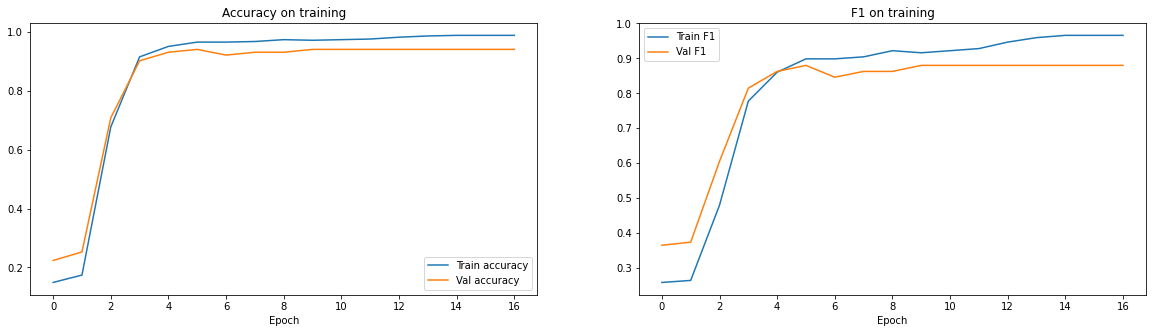

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(history[:, 0], label="Train accuracy")
ax[0].plot(history[:, 2], label="Val accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Accuracy on training")
ax[0].legend()

ax[1].plot(history[:, 1], label="Train F1")
ax[1].plot(history[:, 3], label="Val F1")
ax[1].set_xlabel("Epoch")
ax[1].set_title("F1 on training")
ax[1].legend();

In [ ]:
print("Best model:")
#model.load(model_path_dir)
y_pred, y_true = predict(model, test_dataloader, device)
print(f"Test accuracy: {(y_pred == y_true).float().mean().item():.4f}")
print(f"Test f1_score: {f1_score(y_true.cpu(), y_pred.cpu()):.4f}")

Best model:
Test accuracy: 0.9126
Test f1_score: 0.7907


In [ ]:
from torch.autograd import grad
n_steps = 50
idx = 3

def preds_and_grads(inputs, model, baselines=None, n_steps=50, target=1, numpy=False):
    """
    function to get predictions and gradients of the output wrt features values
    
    Args:
        inputs : Tensor of inputs
        model : pytorch model
        baselines : Tensor or None of baselines 
        n_steps : int number of steps to approximate integrated gradients
        target : int target class
        numpy : bool if true return numpy, else Tensor
    """
    if inputs.dim() == 3:
        inputs = inputs.unsqueeze(0)
    
    if baselines == None:
        baselines = torch.zeros_like(inputs)
    
    # k/m in the formula
    alphas = torch.linspace(0, 1, n_steps).tolist()
    
    # direct path from baseline to input. shape : ([n_steps, n_features], )
    scaled_features = tuple(
            torch.cat(
                [baseline + alpha * (input - baseline) for alpha in alphas], dim=0
            ).requires_grad_()
            for input, baseline in zip(inputs, baselines)
        )
    # predictions at every step. shape : [n_steps, 1]
    preds = model(scaled_features[0])[:, target]
    # gradients of predictions wrt input features. shape : [n_steps, n_features]
    grads = grad(outputs=torch.unbind(preds), inputs=scaled_features)
    if numpy:
        return preds.detach().numpy(), grads[0].detach().numpy()
    return preds, grads
    
preds, grads = preds_and_grads(torch.tensor(torch.from_numpy(train_dataloader.dataset.x[idx:idx+1]).type(torch.FloatTensor)), model, n_steps=n_steps, target=train_dataloader.dataset.y[idx], numpy=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
attr = grads.squeeze(1).mean(0) * train_dataloader.dataset.x[idx].squeeze(0)
attr

array([-0.,  0., -0., ..., -0., -0.,  0.])

In [ ]:
def decode(arr):
    split_arr = np.array_split(arr, 4)
    attr_seq = np.empty(len(split_arr[0]), np.float64)
    label_dict = {'A' : np.zeros(len(split_arr[0]), np.float64),
                  'C' : np.zeros(len(split_arr[0]), np.float64),
                  'G' : np.zeros(len(split_arr[0]), np.float64),
                  'T' : np.zeros(len(split_arr[0]), np.float64)}
    label_seq = ['0'] * len(split_arr[0])
    for j in range(len(split_arr)):
        name = split_arr[j]
        for i in range(len(name)):
            if name[i] != 0:
                label_dict[list(label_dict)[j]][i] = name[i]
                label_seq[i] = (list(label_dict)[j])
                attr_seq[i] = name[i]
    return label_dict, attr_seq, label_seq

In [ ]:
label_dict, attr_seq, label_seq = decode(attr)

In [ ]:
type(train_dataloader.dataset.y[idx])

numpy.int64

In [ ]:
attr

array([-0.,  0., -0., ..., -0., -0.,  0.])

In [ ]:
df = pd.DataFrame(data=label_dict)

In [ ]:
df1 = df.head(20)

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


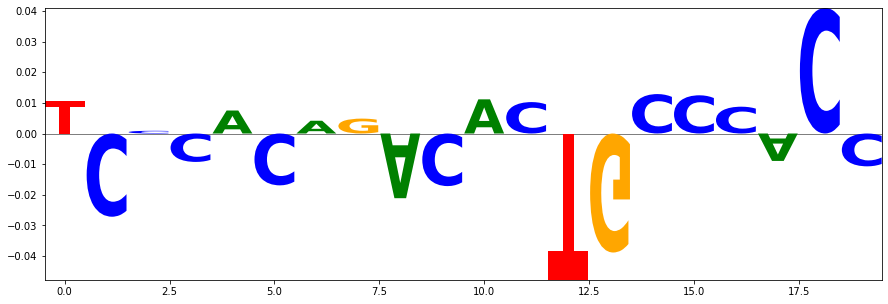

In [ ]:
logo = lm.Logo(df1, font_name = 'Arial Rounded MT Bold', figsize=(15,5))

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
plt.rcParams.update({'font.size': 11})

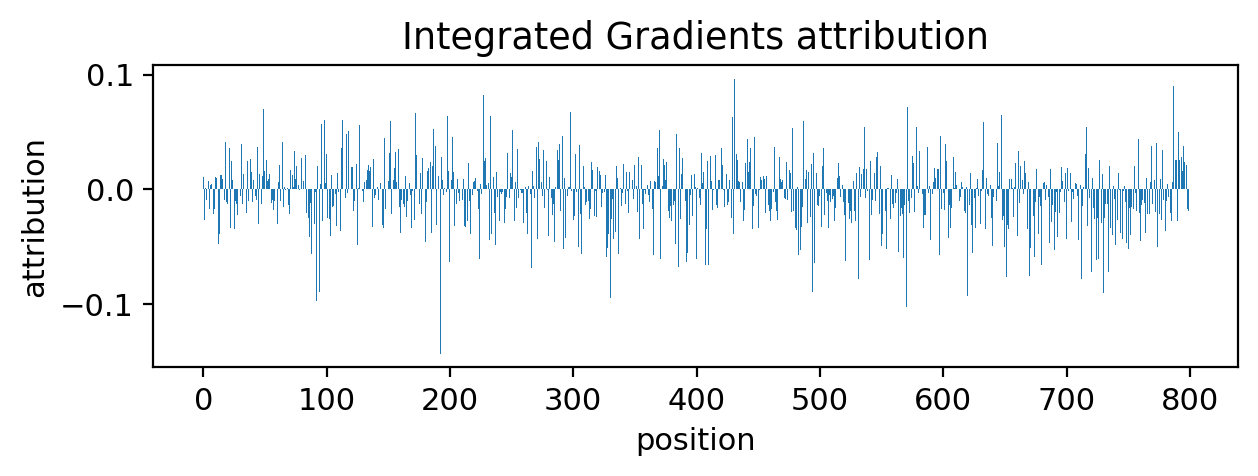

In [ ]:
figure(figsize=(7, 2), dpi=200)

plt.bar(range(len(attr_seq)), attr_seq)
plt.xlabel('position')
plt.ylabel('attribution')
plt.title('Integrated Gradients attribution')
plt.show()

In [ ]:
! pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from captum.attr import IntegratedGradients, InputXGradient, DeepLift, GradientShap
from captum.metrics import sensitivity_max, infidelity

In [ ]:
ig = IntegratedGradients(model)

In [ ]:
attributions_ig, approximation_error = ig.attribute(torch.from_numpy(train_dataloader.dataset.x[idx:idx+2]).type(torch.FloatTensor), target=int(train_dataloader.dataset.y[idx]))

In [ ]:
label_dict_ig, attr_seq_ig, label_seq_ig = decode(attributions_ig.squeeze().numpy())

In [ ]:
df = pd.DataFrame(data=label_dict_ig)
df1 = df.head(20)

In [ ]:
df1.shape[0]

20

In [ ]:
from matplotlib.ticker import MaxNLocator

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


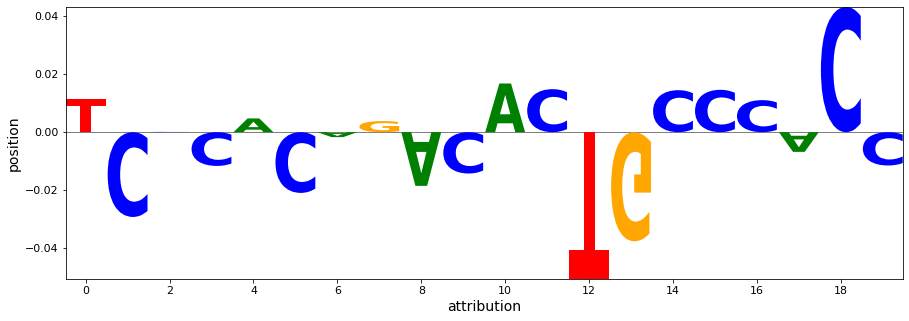

In [ ]:
logo = lm.Logo(df1, font_name = 'Arial Rounded MT Bold', figsize=(15,5))
logo.ax.set_xlabel('attribution',fontsize=14)
logo.ax.set_ylabel("position", fontsize=14)
logo.ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
plt.rcParams['font.size'] = '10'

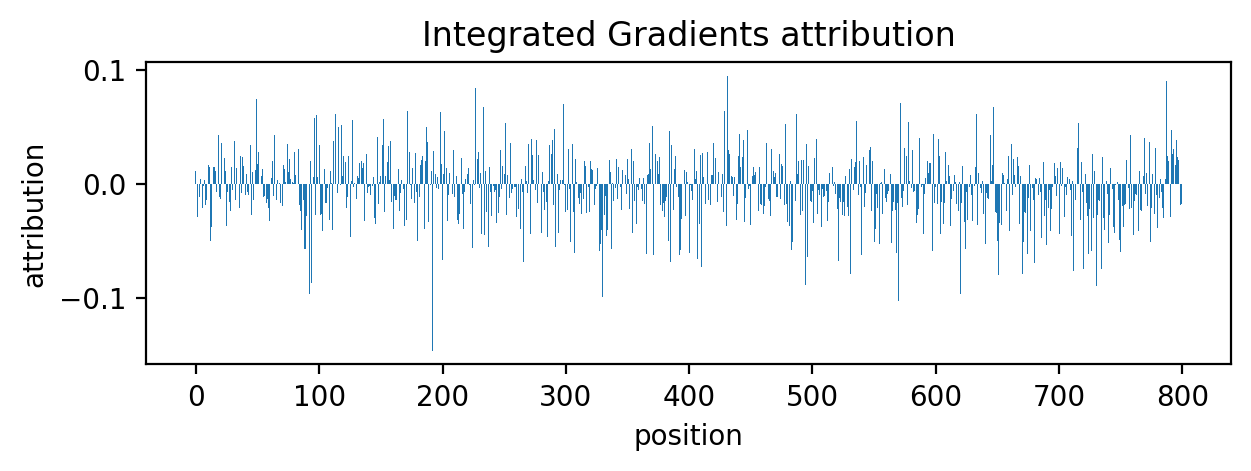

In [ ]:
figure(figsize=(7, 2), dpi=200)

plt.bar(range(len(attr_seq_ig)), attr_seq_ig)
plt.xlabel('position')
plt.ylabel('attribution')
plt.title('Integrated Gradients attribution')
plt.show()

In [ ]:
input_x_gradient = InputXGradient(model)

In [ ]:
attributions_ixg = input_x_gradient.attribute(torch.from_numpy(train_dataloader.dataset.x[idx:idx+1]).type(torch.FloatTensor), target=int(train_dataloader.dataset.y[idx]))

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [ ]:
attributions_ixg.shape

torch.Size([1, 1, 3200])

In [ ]:
label_dict_ixg, attr_seq_ixg, label_seq_ixg = decode(attributions_ixg.squeeze().detach().numpy())

In [ ]:
df = pd.DataFrame(data=label_dict_ixg)
df1 = df.head(20)

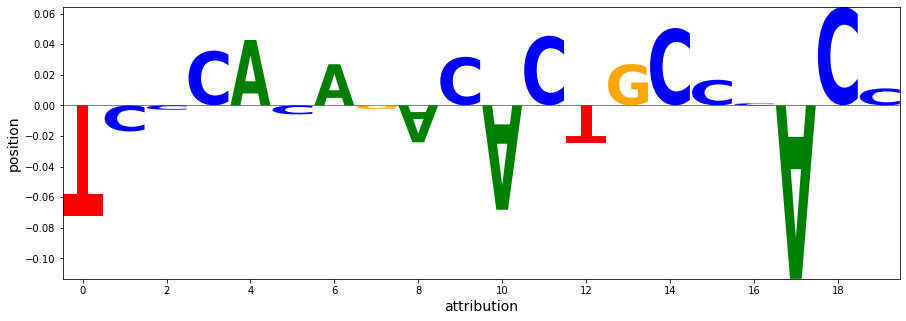

In [ ]:
logo = lm.Logo(df1, font_name = 'Arial Rounded MT Bold', figsize=(15,5))
logo.ax.set_xlabel('attribution',fontsize=14)
logo.ax.set_ylabel("position", fontsize=14)

logo.ax.xaxis.set_major_locator(MaxNLocator(integer=True))

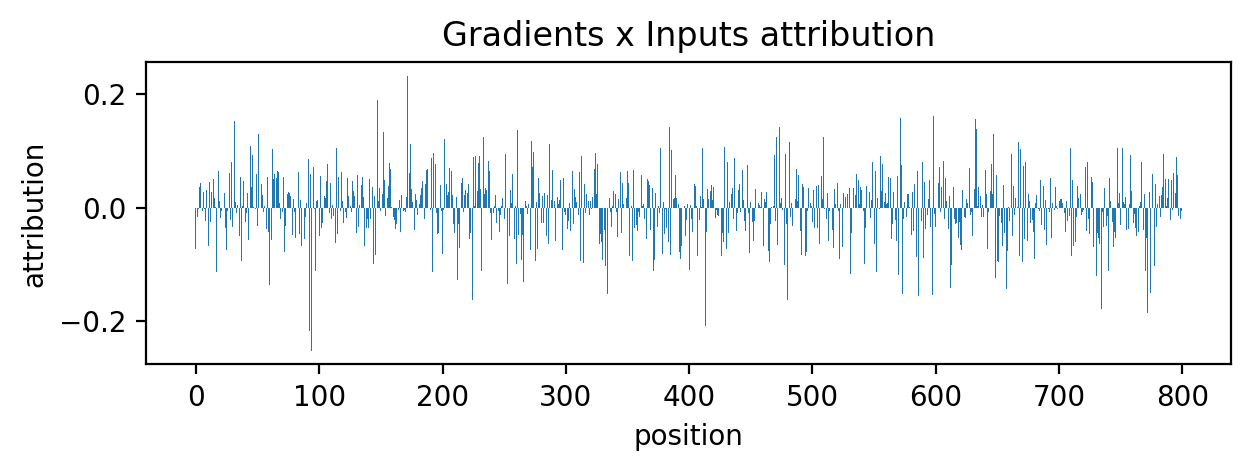

In [ ]:
figure(figsize=(7, 2), dpi=200)

plt.bar(range(len(attr_seq_ixg)), attr_seq_ixg)
plt.xlabel('position')
plt.ylabel('attribution')
plt.title('Gradients x Inputs attribution')
plt.show()

In [ ]:
dl = DeepLift(model)

In [ ]:
attributions_dl = dl.attribute(torch.from_numpy(train_dataloader.dataset.x[idx:idx+1]).type(torch.FloatTensor), target=int(train_dataloader.dataset.y[idx]))

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  module
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size

In [ ]:
label_dict_dl, attr_seq_dl, label_seq_dl = decode(attributions_dl.squeeze().detach().numpy())

In [ ]:
df = pd.DataFrame(data=label_dict_dl)
df1 = df.head(20)

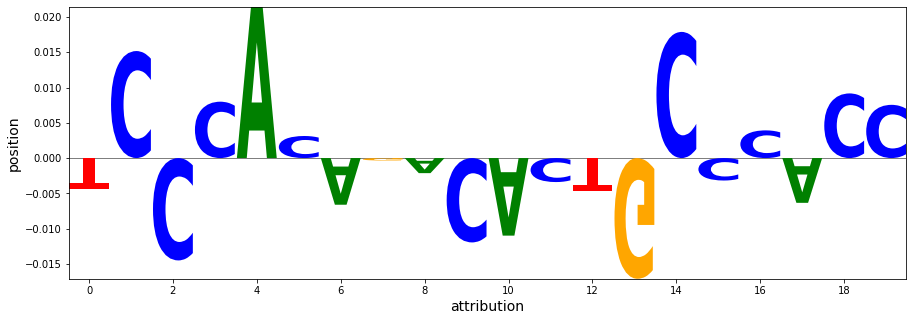

In [ ]:
logo = lm.Logo(df1, font_name = 'Arial Rounded MT Bold', figsize=(15,5))
logo.ax.set_xlabel('attribution',fontsize=14)
logo.ax.set_ylabel("position", fontsize=14)

logo.ax.xaxis.set_major_locator(MaxNLocator(integer=True))

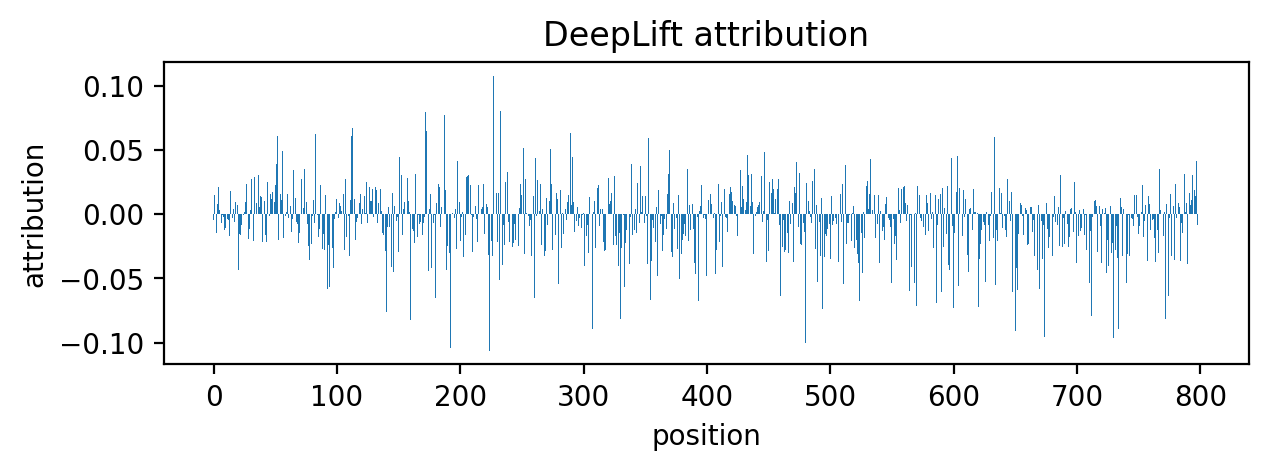

In [ ]:
figure(figsize=(7, 2), dpi=200)

plt.bar(range(len(attr_seq_dl)), attr_seq_dl)
plt.xlabel('position')
plt.ylabel('attribution')
plt.title('DeepLift attribution')
plt.show()

In [ ]:
gradient_shap = GradientShap(model)

In [ ]:
attributions_gs = gradient_shap.attribute(torch.from_numpy(train_dataloader.dataset.x[idx:idx+1]).type(torch.FloatTensor), torch.zeros_like(torch.from_numpy(train_dataloader.dataset.x[idx:idx+1]).type(torch.FloatTensor)),target=int(train_dataloader.dataset.y[idx]))

In [ ]:
label_dict_gs, attr_seq_gs, label_seq_gs = decode(attributions_gs.squeeze().detach().numpy())

In [ ]:
df = pd.DataFrame(data=label_dict_gs)
df1 = df.head(20)

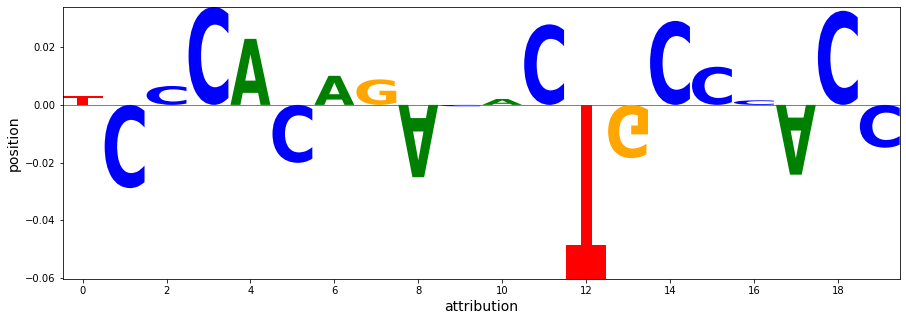

In [ ]:
logo = lm.Logo(df1, font_name = 'Arial Rounded MT Bold', figsize=(15,5))
logo.ax.set_xlabel('attribution',fontsize=14)
logo.ax.set_ylabel("position", fontsize=14)

logo.ax.xaxis.set_major_locator(MaxNLocator(integer=True))

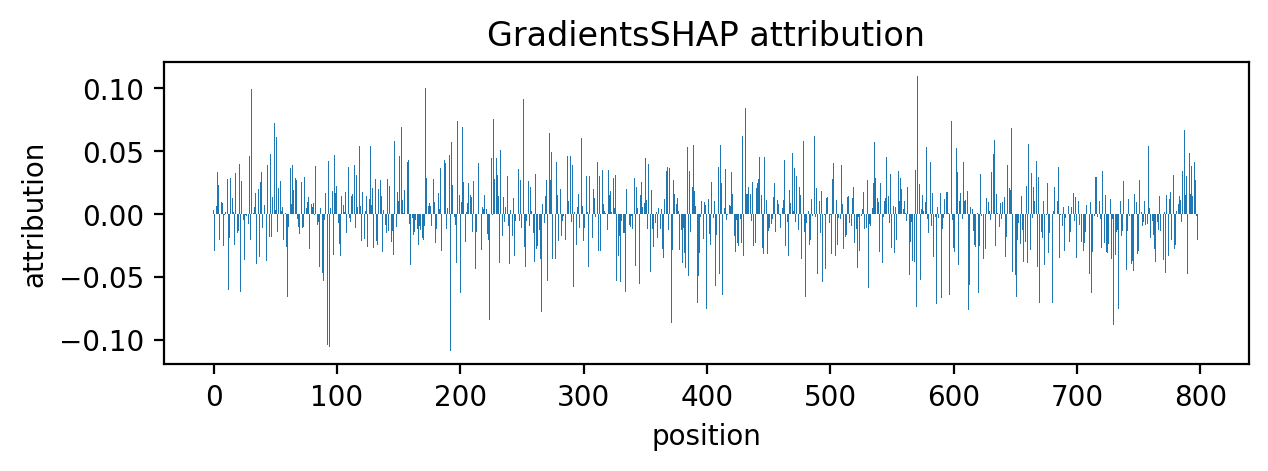

In [ ]:
figure(figsize=(7, 2), dpi=200)

plt.bar(range(len(attr_seq_gs)), attr_seq_gs)
plt.xlabel('position')
plt.ylabel('attribution')
plt.title('GradientsSHAP attribution')
plt.show()

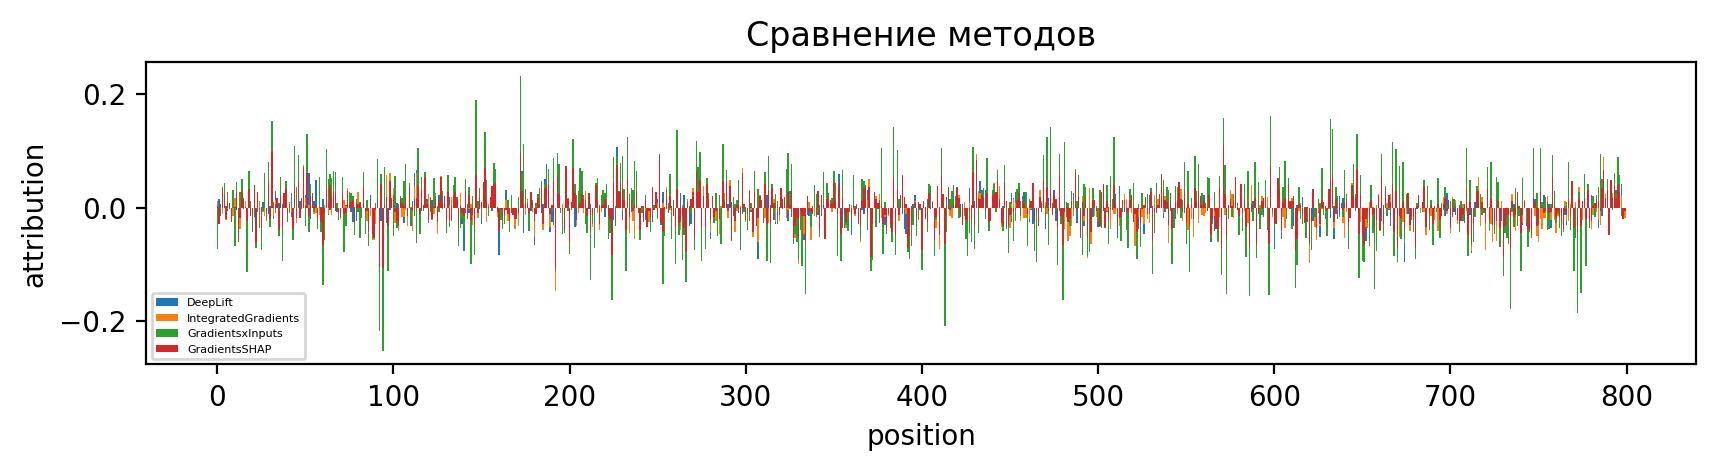

In [ ]:
figure(figsize=(10, 2), dpi=200)

plt.bar(range(len(attr_seq_dl)), attr_seq_dl)
plt.bar(range(len(attr_seq_ig)), attr_seq_ig)
plt.bar(range(len(attr_seq_ig)), attr_seq_ixg)
plt.bar(range(len(attr_seq_ig)), attr_seq_gs)
plt.xlabel('position')
plt.ylabel('attribution')
plt.title('Сравнение методов')
plt.legend(('DeepLift', 'IntegratedGradients', 'GradientsxInputs', 'GradientsSHAP'), loc=3, prop={'size': 4})
plt.show()